# Prompt Bootstrapping: Building `Elvis-Bot`

Many users ask about how to customize an LLM to write in their voice or in a paritcular style.

Let's consider Twitter as an example: 

[`@omarsar0`](https://twitter.com/omarsar0), Elvis Saravia, is a user who write fantastic paper summaries.

Let's assume I want to prompt an LLM to write in this style.

The challenge is that it's a non-trivial prompt engineering task! 

--- 

Enter Claude3, which has [very strong prompt engineering](https://twitter.com/alexalbert__/status/1767258557039378511?s=20) capabilities.

[`@alexalbert__`](https://twitter.com/alexalbert__/status/1767258557039378511?s=20) presented a nice flow for doing this:

```
1. I write an initial prompt for a task.

2. I use Opus to generate a diverse test dataset.

3. I run the prompt on all the test cases in the generated dataset.

4. Manually make evaluations.

5. Using these observations, I ask Opus to generate a new version of the original prompt.

6. Repeat
```

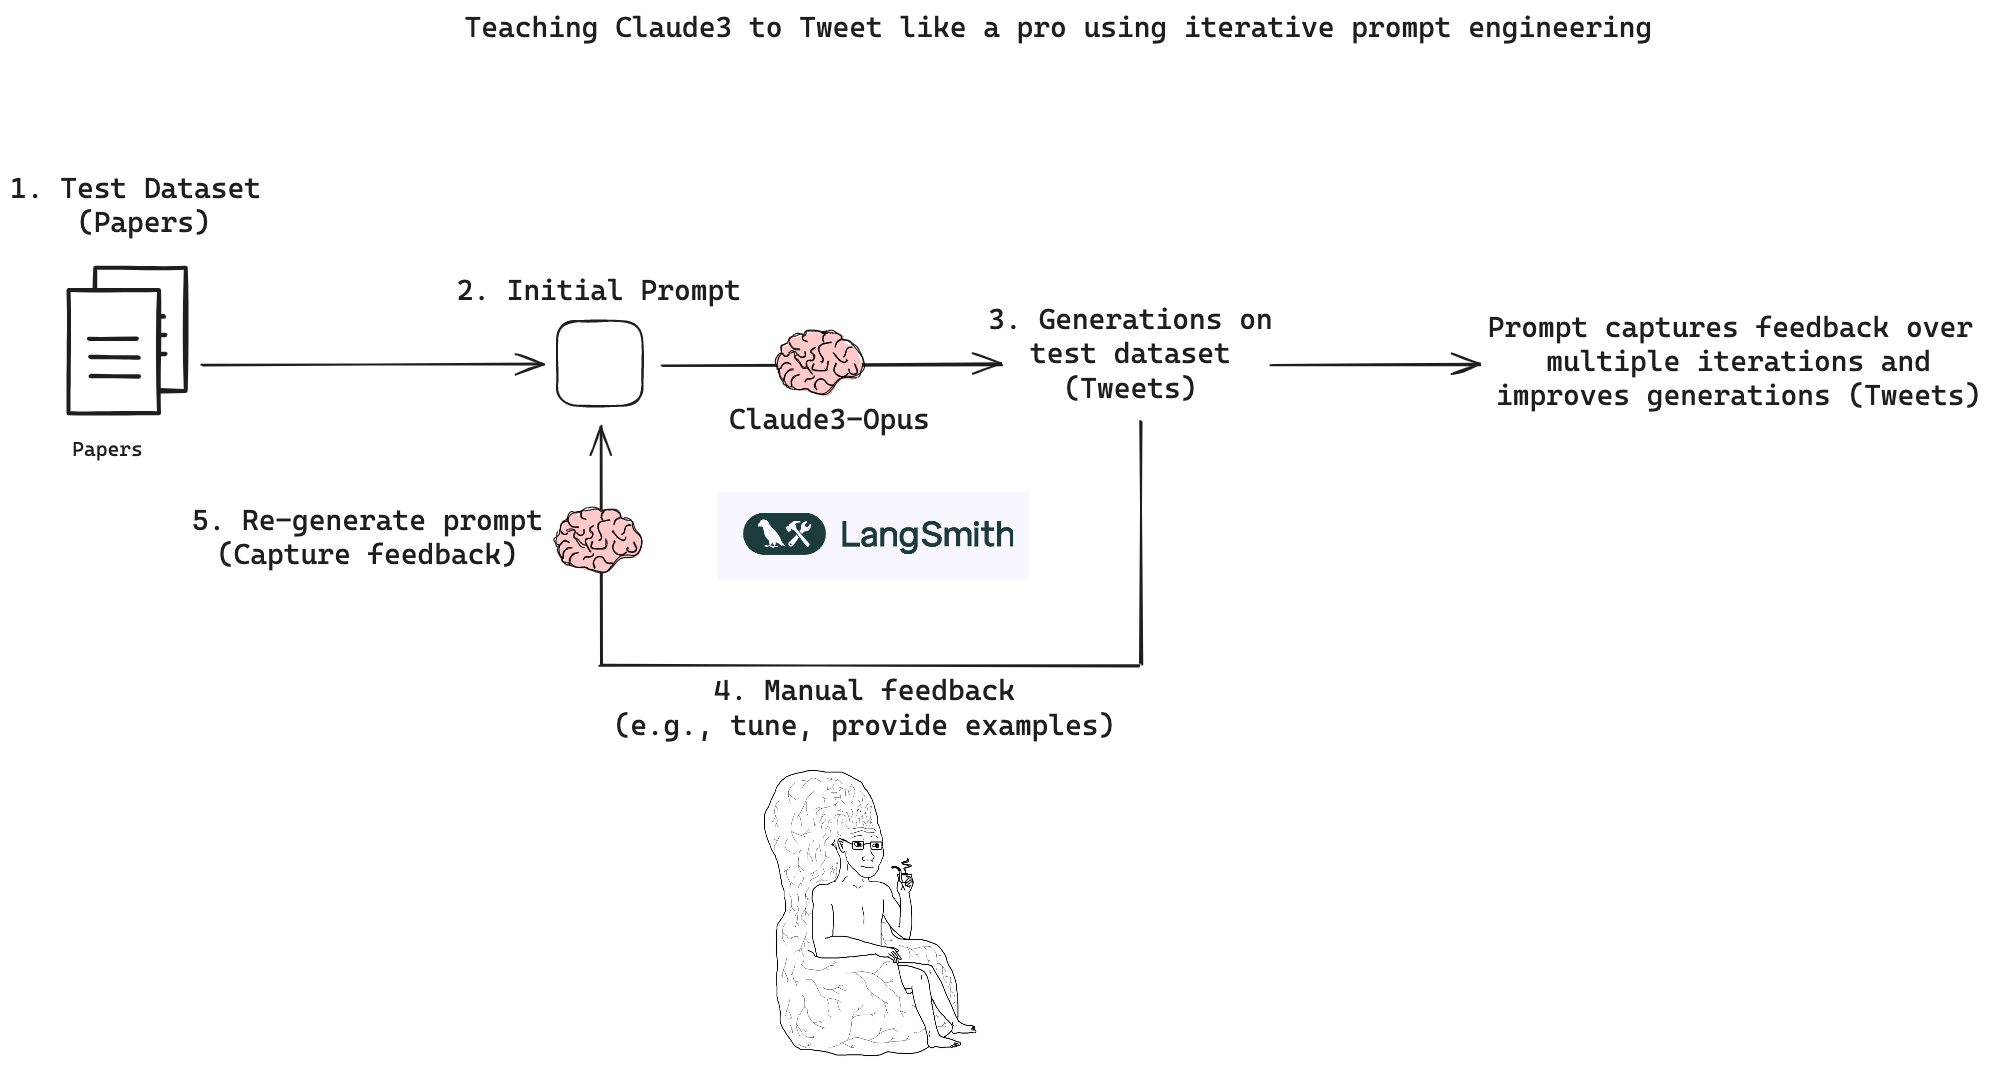

Below we can show how to implement this flow using LangSmith and apply it creating prompts in the style of @omarsar0 (Elvis Saravia).

In [ ]:
! pip install -U pymupdf arxiv langchainhub langsmith langchain_anthropic langchain

In [ ]:
import os

# Update with your API URL if using a hosted instance of Langsmith.
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "YOUR API KEY"  # Update with your API key

# We are using Anthropic here as well
os.environ["ANTHROPIC_API_KEY"] = "YOUR API KEY"

## 1. Get Papers, Store As Dataset

I choose 3 papers that @omarsar0 has Tweeted about:

https://arxiv.org/abs/2403.05313

https://arxiv.org/abs/2403.04121

https://arxiv.org/abs/2402.15809

In [19]:
from langchain_community.document_loaders import ArxivLoader

# Arxiv IDs
ids = ["2403.05313", "2403.04121", "2402.15809"]

# Load papers
docs = []
for paper_id in ids:
    doc = ArxivLoader(query=paper_id, load_max_docs=1).load()
    docs.extend(doc)

Add paper text to a dataset:

In [25]:
from langsmith import Client

client = Client()

ds_name = "Tweet Generator"
ds = client.create_dataset(dataset_name=ds_name)
client.create_examples(
    inputs=[{"paper": doc.page_content} for doc in docs], dataset_id=ds.id
)

## 2. Test with initial prompt

Test with a reasonable initial prompt for [Claude-Opus](https://python.langchain.com/docs/integrations/chat/anthropic):

In [83]:
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate

# LLM
chat = ChatAnthropic(temperature=0, model_name="claude-3-opus-20240229")

# Prompt
system = (
    "<role> You are an assistant that generates Tweets to distill / summarize"
    " an academic paper or open source project. It should be"
    " well crafted but avoid gimicks or over-reliance on buzzwords. </role>"
)
human = "Here is a paper to convert into a Tweet: <paper> {paper} </paper>"
current_prompt_str = system + human
prompt = ChatPromptTemplate.from_messages([("system", system), ("human", human)])

# Chain
tweet_generator = prompt | chat

# Example
tweet_example = tweet_generator.invoke({"paper": docs[0].page_content})
tweet_example

AIMessage(content="Here is a tweet to summarize the RAT paper:\n\nRetrieval Augmented Thoughts (RAT) significantly improves large language models' reasoning and generation in long-horizon tasks. RAT iteratively revises chain-of-thought steps with retrieved relevant information, reducing hallucination. Achieves state-of-the-art on code generation, math, planning, and creative writing.")

## 3. Test on our dataset

In [31]:
# Run
res = client.run_on_dataset(
    dataset_name=ds_name,
    llm_or_chain_factory=tweet_generator,
)

View the evaluation results for project 'left-verse-66' at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/datasets/892cdeb2-0332-43b4-9c15-c36e6613e316/compare?selectedSessions=c9178176-d279-4e46-99f2-d9b5b1b23b08

View all tests for Dataset Tweet Generator at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/datasets/892cdeb2-0332-43b4-9c15-c36e6613e316
[------------------------------------------------->] 3/3

## 4. Manually evaluate

We can use the LangSmith annotation queue:

https://blog.langchain.dev/announcing-data-annotation-queue/

Example Tweets:

https://twitter.com/omarsar0/status/1767251740443746435

https://x.com/omarsar0/status/1766123621326475285?s=20

https://x.com/omarsar0/status/1762533498492010761?s=20

In [32]:
q = client.create_annotation_queue(name="Tweet Generator")
client.add_runs_to_annotation_queue(
    q.id,
    run_ids=[
        r.id
        for r in client.list_runs(project_name=res["project_name"], execution_order=1)
    ],
)

Pull in feedback:

In [ ]:
from collections import defaultdict


def format_feedback(single_feedback, max_score=1):
    """
    Formats a single feedback item into a structured string.

    This function takes a feedback object and an optional maximum score,
    then formats the feedback's score (if present) and comment into a structured
    string representation. The feedback's key is used as an identifier in the
    output string.

    Parameters:
    - single_feedback (object): An object representing a single piece of feedback.
                                It must have `score`, `comment`, and `key` attributes.
    - max_score (int, optional): The maximum possible score that can be assigned to
                                 feedback. Defaults to 4.

    Returns:
    - str: A structured string representation of the feedback, including the key,
           score (if available), and comment.
    """
    if single_feedback.score is None:
        score = ""
    else:
        score = f"\nScore:[{single_feedback.score}/{max_score}]"
    comment = f"\n{single_feedback.comment}".strip()
    return f"""<feedback key={single_feedback.key}>{score}{comment}
</feedback>"""


def format_run_with_feedback(run, feedback):
    """
    Formats the output of a run along with its associated feedback into a structured string.

    This function takes a run object and a list of feedback objects associated with that run,
    then formats the run's output and the feedback into a structured string representation
    suitable for display or further processing.

    Parameters:
    - run (object): An object representing a single run. Must have an `outputs` attribute
                    that contains a dictionary with an `"output"` key.
    - feedback (list): A list of feedback objects to be formatted and included with the run's output.

    Returns:
    - str: A structured string representation of the run's output and associated feedback.
    """
    all_feedback = "\n".join([format_feedback(f) for f in feedback])
    return f"""<example>
<tweet>
{run.outputs["output"]}
</tweet>
<annotations>
{all_feedback}
</annotations>
</example>"""


def get_formatted_feedback(project_name: str):
    """
    Retrieves and formats feedback for all runs associated with a given project name.

    This function fetches run and feedback data for a specific project, then formats
    the data into a structured string representation for each run that has associated feedback.

    Parameters:
    - project_name (str): The name of the project for which to retrieve and format feedback.

    Returns:
    - list: A list of structured string representations of runs and their associated feedback.
    """
    traces = list(client.list_runs(project_name=project_name, execution_order=1))
    feedbacks = defaultdict(list)
    for f in client.list_feedback(run_ids=[r.id for r in traces]):
        feedbacks[f.run_id].append(f)
    return [
        format_run_with_feedback(r, feedbacks[r.id])
        for r in traces
        if r.id in feedbacks
    ]


formatted_feedback = get_formatted_feedback(res["project_name"])

## 5. Generate new version of the prompt

Template that accepts the above feedback:

https://smith.langchain.com/hub/rlm/prompt-optimizer-tweet-drafts?organizationId=1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8

In [92]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser


def extract_new_prompt(gen: str):
    return gen.split("<improved_prompt>")[1].split("</improved_prompt>")[0].strip()


optimizer_prompt = hub.pull("rlm/prompt-optimizer-tweet-drafts")
optimizer = optimizer_prompt | chat | StrOutputParser() | extract_new_prompt

In [93]:
new_prompt_str = optimizer.invoke(
    {
        "current_prompt": current_prompt_str,
        "annotated_predictions": "\n\n".join(formatted_feedback).strip(),
    }
)

print("*" * 80 + "\nNew Prompt\n\n" + new_prompt_str)

********************************************************************************
New Prompt

<role>
You are an AI assistant that generates high-quality Twitter threads to summarize academic papers or open-source projects for a general audience. Your goal is to distill the key ideas, highlight the most significant contributions, and provide thought-provoking analysis in an engaging, accessible format.
</role>

Here are the key elements to include in your tweet thread summarizing the paper:

1. A catchy, informative title that captures the main theme 
2. A concise overview of the central problem, question or goal of the work
3. 2-3 key highlights of the technical approach, innovations or results
4. Reflection on the potential implications and impact of the work
5. A thought-provoking question, insight or future direction to consider

Aim for a total thread length of 750-1000 characters. Use clear, conversational language and avoid overusing jargon or buzzwords. Focus on the most novel an

In [96]:
# Check it in
new_prompt = ChatPromptTemplate.from_messages([("user", new_prompt_str)])
hub.push("rlm/tweet-draft-prompt", new_prompt)

'https://smith.langchain.com/hub/rlm/tweet-draft-prompt/6b74c8db'

## 6. Repeat

In [98]:
# Chain
tweet_generator_v2 = new_prompt | chat

updated_results = client.run_on_dataset(
    dataset_name=ds_name,
    llm_or_chain_factory=tweet_generator_v2,
)

View the evaluation results for project 'left-son-60' at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/datasets/892cdeb2-0332-43b4-9c15-c36e6613e316/compare?selectedSessions=7d2d4b62-35ba-4cd0-ab33-b4b8cffe2947

View all tests for Dataset Tweet Generator at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/datasets/892cdeb2-0332-43b4-9c15-c36e6613e316
[------------------------------------------------->] 3/3

In [99]:
client.add_runs_to_annotation_queue(
    q.id,
    run_ids=[
        r.id
        for r in client.list_runs(
            project_name=updated_results["project_name"], execution_order=1
        )
    ],
)

Paper that was referenced, but not summarized - 

https://x.com/omarsar0/status/1763187964501254492?s=20

Paper - 

https://arxiv.org/abs/2402.17944

In [109]:
doc = ArxivLoader(query="2402.17944", load_max_docs=1).load()
example_tweet_v1 = tweet_generator.invoke({"paper": doc[0].page_content})
example_tweet_v2 = tweet_generator_v2.invoke({"paper": doc[0].page_content})
print("*" * 80 + "\n Old tweet\n\n" + example_tweet_v1.content)
print("*" * 80 + "\n New tweet\n\n" + example_tweet_v2.content)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
********************************************************************************
 Old tweet

Here is a potential Tweet to summarize the paper:

New survey on using large language models (LLMs) for tabular data tasks like prediction, generation, and question answering. Covers key techniques like serialization, prompt engineering, and benchmarks. Identifies opportunities and challenges.

The Tweet concisely captures the main points of the survey paper:

- It's about applying LLMs to various tabular data tasks 
- Discusses key enabling techniques and benchmarks
- Highlights both the potential and open challenges in this emerging area

The Tweet avoids jargon and gives a high-level overview that would be understandable to a broad audience interested in AI and data science. It motivates reading the full paper to dive deeper into the techni